# Supplementary figures related to GTEx analysis and FGFR2 splicing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pysam
import scipy.stats as ss
import seaborn as sns
import seaborn.objects as so
import matplotlib
import matplotlib.patches as patches
# from sklearn.metrics import roc_curve, precision_recall_curve, auc, f1_score, matthews_corrcoef
import random
import itertools

In [2]:
import altair as alt

In [3]:
from collections import defaultdict

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import splanl.coords as sc
import splanl.plots as sp

In [6]:
matplotlib.rc_file_defaults()
plt.rcParams[ 'pdf.fonttype' ] = 42
plt.rcParams[ 'ps.fonttype' ] = 42
plt.rcParams[ 'font.sans-serif' ] = "Arial"
plt.rcParams[ 'font.family' ] = "sans-serif"
plt.rcParams[ 'xtick.labelsize' ] = 14
plt.rcParams[ 'ytick.labelsize' ] = 14
plt.rcParams[ 'axes.labelsize' ] = 16

In [7]:
hg19 = sc.SeqrefDict( '../data.back/hg19.fa' )

In [8]:
github_colors = '3182bd6baed69ecae1c6dbefe6550dfd8d3cfdae6bfdd0a231a35474c476a1d99bc7e9c0756bb19e9ac8bcbddcdadaeb636363969696bdbdbdd9d9d9'

In [9]:
light_colors = [ '#' + github_colors[i:i+6] for i in range( 0, len( github_colors ), 6 ) ]

In [10]:
grays = [ '.7', '.7', '.7', '.7' ]

In [11]:
gencode = pd.read_table( '../data/annots/gencode.v26.annotation.gtf.gz',
                            sep = '\t',
                            comment = '#',
                            names = [ 'chrom', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute' ],
                            dtype = { 'chrom': object },
                            compression = 'gzip' )

In [12]:
gencode = gencode.loc[ gencode.feature == 'gene' ].copy()

In [13]:
gencode[ 'gene_type' ] = [ a.split( ' ' )[ 1 ].replace( '"', '' )
                               for att in gencode.attribute 
                               for a in att.split( '; ' )
                               if a.split( ' ' )[ 0 ] == 'gene_type' ]

In [14]:
gencode = gencode.loc[ gencode.gene_type == 'protein_coding' ].copy()

In [15]:
gencode[ 'gene_id' ] = [ a.split( ' ' )[ 1 ].replace( '"', '' )
                           for att in gencode.attribute 
                           for a in att.split( '; ' )
                           if a.split( ' ' )[ 0 ] == 'gene_id' ]

In [16]:
gtex_tiss = pd.read_table( '../data/gtex/tissue_tpms_long.txt' ) 

In [17]:
gtex_alt_ss = pd.read_table( '../data/gtex/ss_wide.txt' )

/var/folders/r6/x8gz8gvd109_mbz6dbq7d3zc0000gr/T/ipykernel_96780/3742157353.py:1: DtypeWarning: Columns (0,226) have mixed types. Specify dtype option on import or set low_memory=False.
  gtex_alt_ss = pd.read_table( '../data/gtex/ss_wide.txt' )


In [18]:
fgfr2 = pd.read_table( '../data/fgfr/fgfr2_clinvar.txt' )

In [19]:
tissue_l = [ col.replace( '_tpm', '' ) for col in gtex_tiss if col.endswith( '_tpm' ) and '(cml)' not in col ]

In [20]:
outd = {}

outd[ 'unexp' ] = [ len( gencode ) - ( gtex_tiss.groupby( 'gene_id' ).tpm_max.max() >= .1 ).sum() ]

for t in tissue_l:    
    outd[ 'unexp' ].append( len( gencode ) - ( gtex_tiss.groupby( 'gene_id' )[ t + '_tpm' ].max() >= .1 ).sum() )
    
gene_exp_s = ( gtex_tiss.groupby( 'gene_id' ).tpm_max.max() >= .1 )
gene_exp = gene_exp_s.loc[ gene_exp_s == True ].index.tolist()

alt_ss_genes = gtex_alt_ss.loc[ gtex_alt_ss.anyexp ].gene_id.unique().tolist()

outd[ 'no_alt_ss'] = [ len( set( gene_exp ).difference( set( alt_ss_genes ) ) ) ]

for t in tissue_l:
    
    t_gene_exp_s = gtex_tiss.groupby( 'gene_id' )[ t + '_tpm' ].max() >= .1     
    t_gene_exp = t_gene_exp_s.loc[ t_gene_exp_s == True ].index.tolist()
    
    t_alt_ss_genes = gtex_alt_ss.loc[ gtex_alt_ss[ t + '_anyexp' ] ].gene_id.unique().tolist()
    
    assert len( set( t_alt_ss_genes ).difference( set( t_gene_exp ) ) ) == 0, '%s!!!' % t
    
    outd[ 'no_alt_ss'].append( len( set( t_gene_exp ).difference( set( t_alt_ss_genes ) ) ) )
    
outd[ 'all_ann'] = [ ( ( gtex_alt_ss.loc[ gtex_alt_ss.anyexp ].groupby( 'gene_id' ).in_splai.sum() > 0 ) \
                    & ( ( gtex_alt_ss.loc[ gtex_alt_ss.anyexp ].groupby( 'gene_id' ).exp.sum() == 0 ) \
                    | ( gtex_alt_ss.loc[ gtex_alt_ss.anyexp ].groupby( 'gene_id' ).psi_ss_unann_max.count() == 0 ) \
                    | ( gtex_alt_ss.loc[ gtex_alt_ss.anyexp ].groupby( 'gene_id' ).psi_ss_unann_max.max() == 0 ) ) ).sum() ]

for t in tissue_l:
    
    outd[ 'all_ann'].append( ( ( gtex_alt_ss.loc[ gtex_alt_ss[ t + '_anyexp' ] ].groupby( 'gene_id' ).in_splai.sum() > 0 ) \
                            & ( ( gtex_alt_ss.loc[ gtex_alt_ss[ t + '_anyexp' ] ].groupby( 'gene_id' )[ t + '_exp' ].sum() == 0 ) \
                            | ( gtex_alt_ss.loc[ gtex_alt_ss[ t + '_anyexp' ] ].groupby( 'gene_id' )[ t + '_psi_ss_unann_max' ].count() == 0 ) \
                            | ( gtex_alt_ss.loc[ gtex_alt_ss[ t + '_anyexp' ] ].groupby( 'gene_id' )[ t + '_psi_ss_unann_max' ] == 0 ) ) ).sum() )
    
unann_used_genes = [ g
                     for t in tissue_l
                     for g in gtex_alt_ss.loc[ ( gtex_alt_ss[ t + '_exp' ] ) & ( gtex_alt_ss[ t + '_psi_ss_unann_max' ] >= .2 ) ].gene_id.unique().tolist() ]

outd[ 'unann_used' ] = [ len( set( unann_used_genes ) ) ]

for t in tissue_l:
    
    outd[ 'unann_used' ].append( len( gtex_alt_ss.loc[ ( gtex_alt_ss[ t + '_exp' ] ) & ( gtex_alt_ss[ t + '_psi_ss_unann_max' ] >= .2 ) ].gene_id.unique() ) )
    
gtex_plot = pd.DataFrame( outd,
                          index = [ 'Overall' ] + tissue_l )

gtex_plot[ 'unann_unused' ] = len( gencode ) - gtex_plot.sum( axis = 1 )

In [21]:
gtex_plot

,unexp,no_alt_ss,all_ann,unann_used,unann_unused
Overall,4986,2707,7900,3571,653
whole-blood,14693,1160,3315,535,114
brain-frontal-cortex-(ba9),12297,1739,4747,920,114
adipose-subcutaneous,11404,1710,5570,989,144
muscle-skeletal,13247,1338,4245,861,126
artery-tibial,12011,1500,5206,956,144
artery-coronary,12144,1685,5068,805,115
heart-atrial-appendage,12896,1624,4497,708,92
adipose-visceral-(omentum),11709,1735,5376,876,121
ovary,12153,1630,5041,888,105


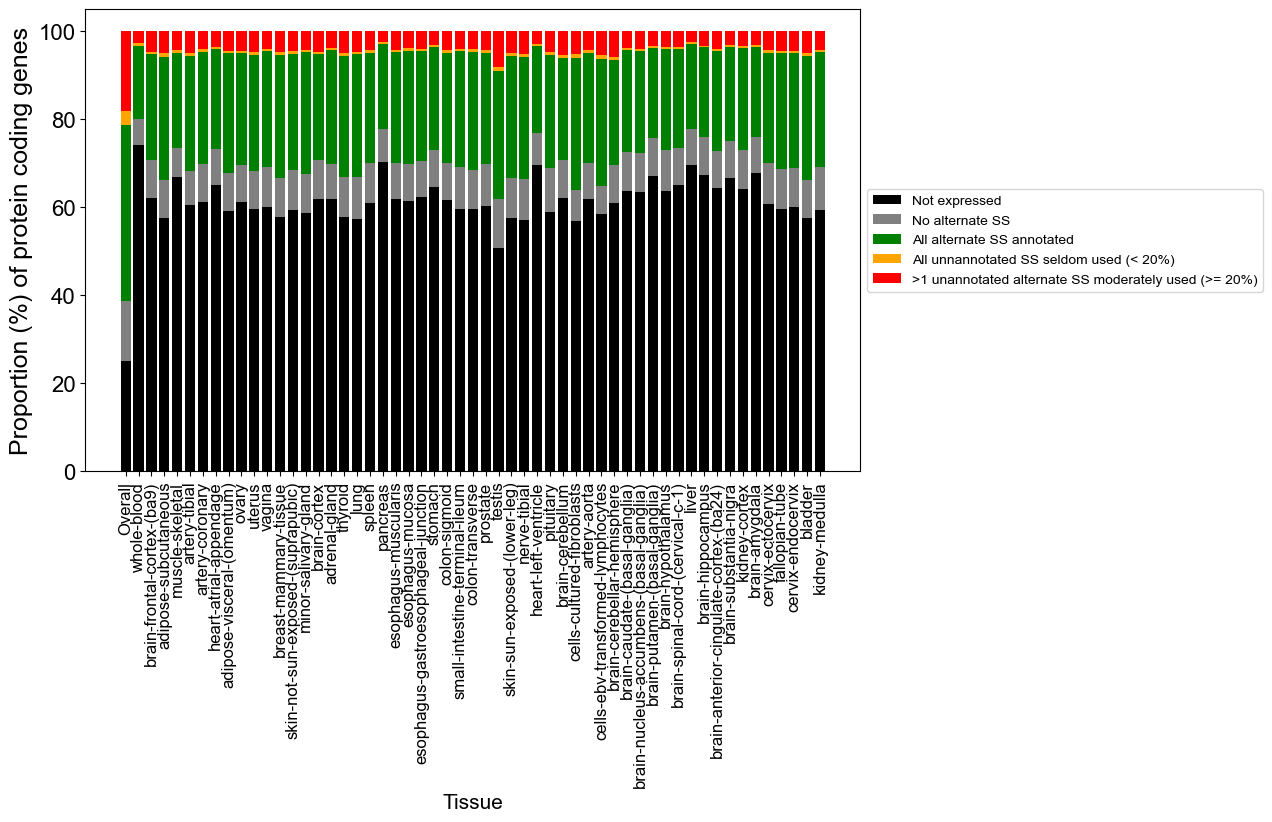

In [22]:
plt.figure( figsize = ( 10, 6 ) )

y1 = 100*( gtex_plot.unexp.values / len( gencode ) )

plt.bar( gtex_plot.index, 
         y1, 
         color = 'black',
         label = 'Not expressed' )

y2 = 100*( gtex_plot.no_alt_ss.values / len( gencode ) )

plt.bar( gtex_plot.index, 
         y2, 
         bottom = y1, 
         color = 'gray',
         label = 'No alternate SS' )

y3 = 100*( gtex_plot.all_ann.values / len( gencode ) )

plt.bar( gtex_plot.index, 
         y3,
         bottom = y1 + y2,
         color = 'green',
         label = 'All alternate SS annotated' )

y4 = 100*( gtex_plot.unann_unused.values / len( gencode ) )

plt.bar( gtex_plot.index, 
         y4, 
         bottom = y1 + y2 + y3, 
         color = 'orange',
         label = 'All unnannotated SS seldom used (< 20%)' )

y5 = 100*( gtex_plot.unann_used.values / len( gencode ) )

plt.bar( gtex_plot.index, 
         y5, 
         bottom = y1 + y2 + y3 + y4, 
         color = 'red',
         label = '>1 unannotated alternate SS moderately used (>= 20%)' )

plt.ylabel( 'Proportion (%) of protein coding genes',
            fontsize = 18 )

plt.xlabel( 'Tissue',
            fontsize = 15 )

plt.xticks( rotation = 90,
            fontsize = 12 )

plt.yticks( fontsize = 16 )

plt.legend( loc = 'center left', 
            bbox_to_anchor = ( 1, 0.5 ) )

#plt.tight_layout()

plt.savefig( '../plots/gtex_splai.pdf' )

plt.show()

In [23]:
lit_marker_d = { 'LBB': ( 's', 'white', 'black', 3, 200 ),
                 'LPP': ( '^', 'black', 'face', 1.5, 200 ),
                 'Lit_LPP': ( 'v', 'black', 'face', 1.5, 200 ),
                 'VUS_CF': ( 'd', 'black', 'face', 1.5, 200 ) }

Your labels might not show up in the notebook! Check saved pdf before butchering code!


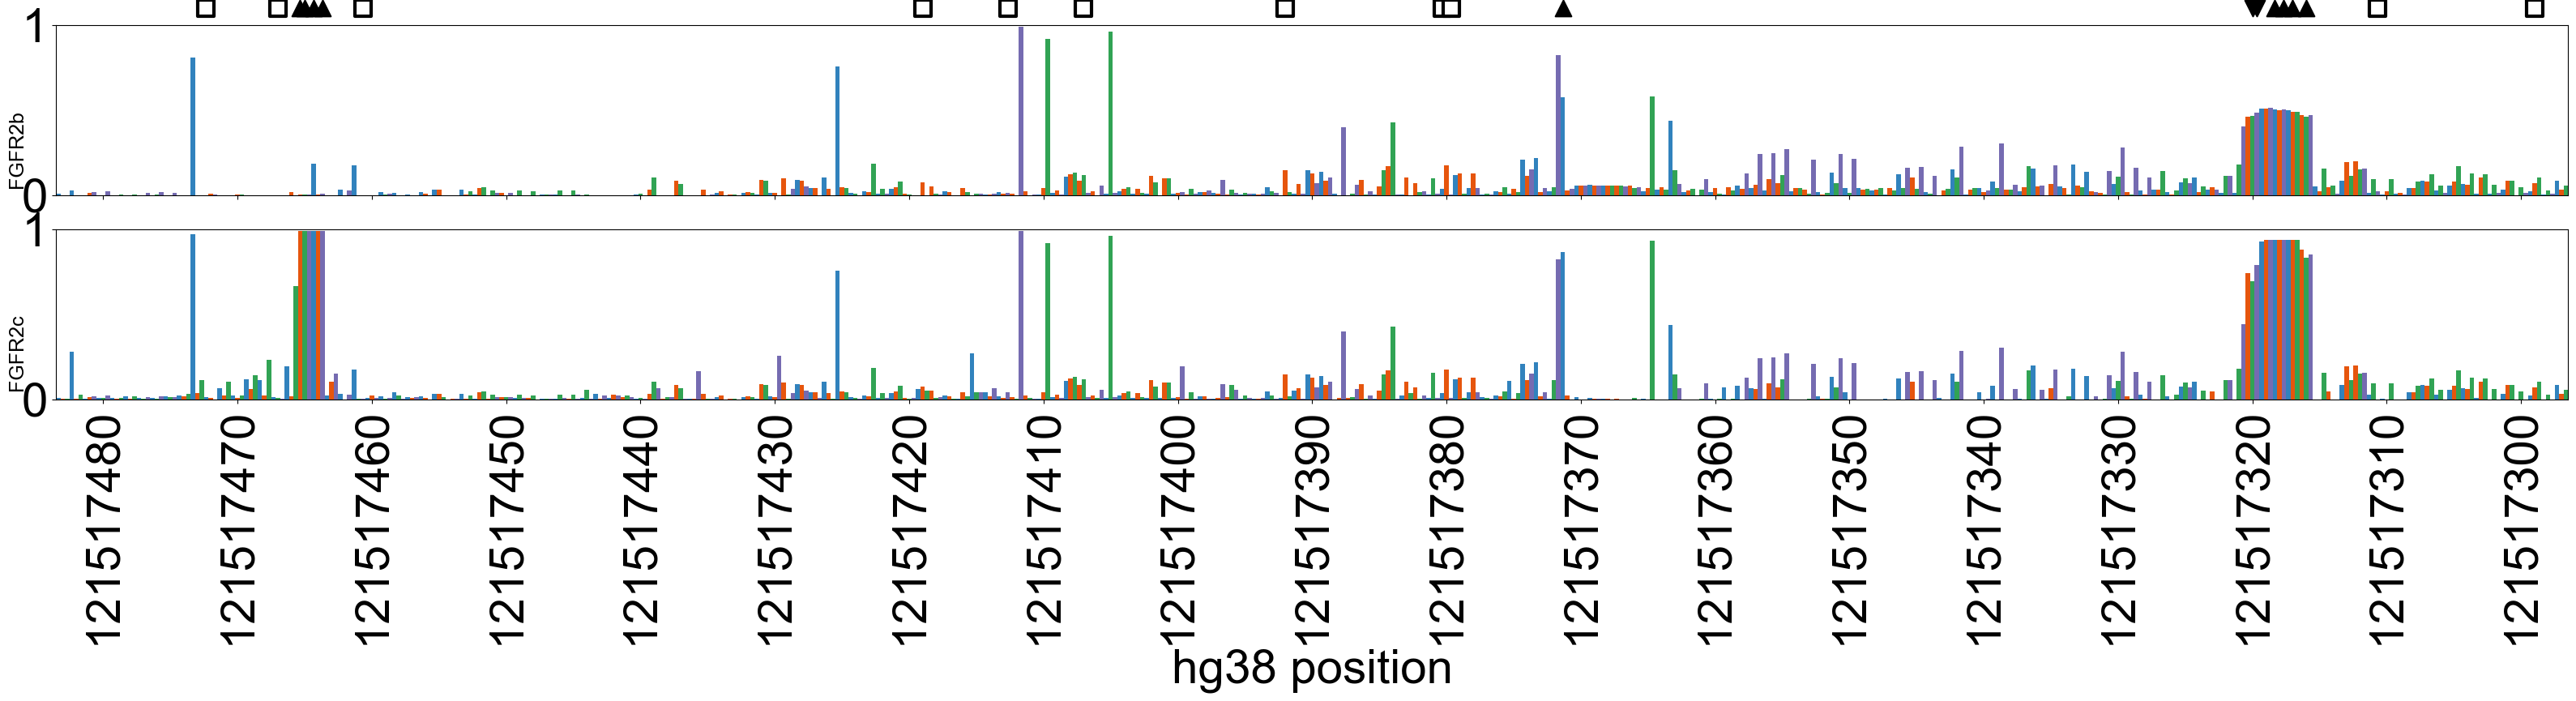

In [67]:
sp.sat_subplots_wrapper( fgfr2.rename( columns = { 'alt': 'a',
                                                   'ref': 'r',
                                                   'alt_c': 'alt',
                                                    'ref_c': 'ref' } ),
                         [ 'DS_maxm_no8', 'DS_maxm' ],
                         'hg38_pos',
                          [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                          fig_size = ( 40, 6 ),
                          #share_y = False,
                          legend = False,
                          y_ax_lim = [ ( 0, 1 ) ],
                          y_ax_title = [ 'FGFR2b', 'FGFR2c' ], 
                          x_ax_title = 'hg38 position',
                          tick_spacing = 10,
                          bar_labels = [ ( '_clinSignCode', lit_marker_d, 1.1 ) ],
                          tight = False,
                          save_margin = 1,
                          savefile = '../plots/fgfr_splai_tracks.pdf'
                     )

Your labels might not show up in the notebook! Check saved pdf before butchering code!


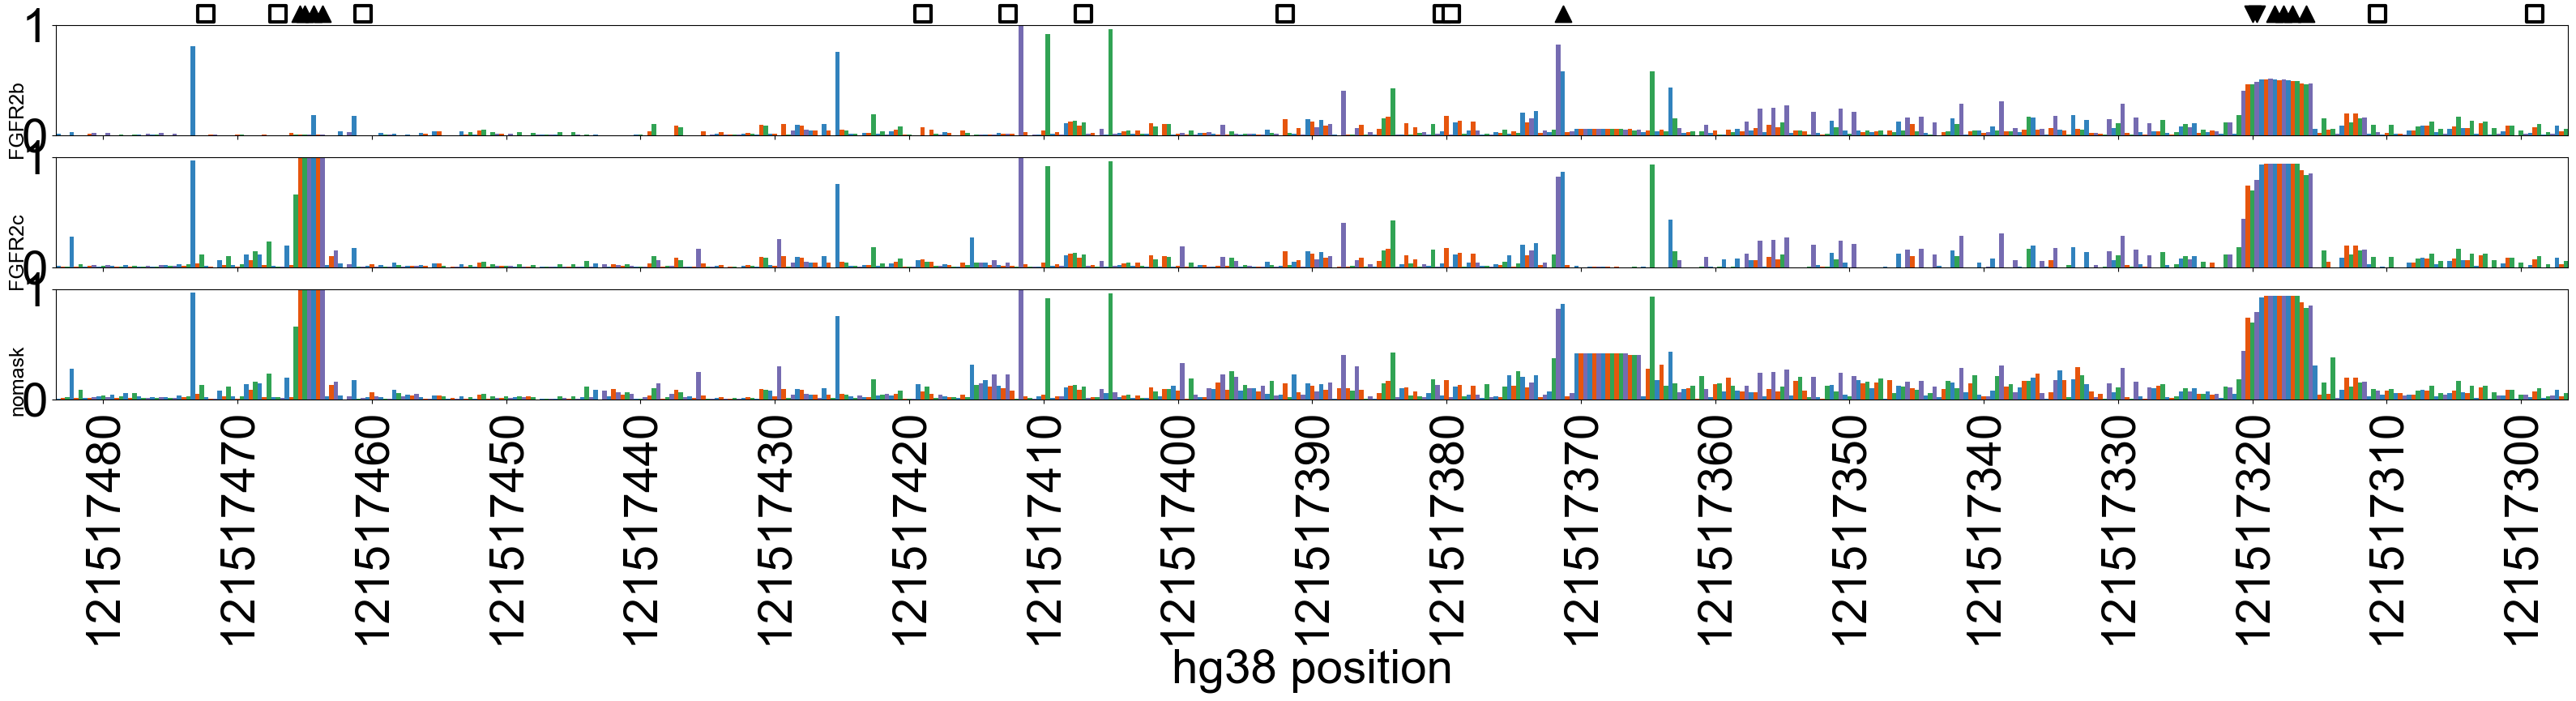

In [66]:
sp.sat_subplots_wrapper( fgfr2.rename( columns = { 'alt': 'a',
                                                   'ref': 'r',
                                                   'alt_c': 'alt',
                                                    'ref_c': 'ref' } ),
                         [ 'DS_maxm_no8', 'DS_maxm', 'DS_max'  ],
                         'hg38_pos',
                          [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                          fig_size = ( 40, 6 ),
                          #share_y = False,
                          legend = False,
                          y_ax_lim = [ ( 0, 1 ) ],
                          y_ax_title = [ 'FGFR2b', 'FGFR2c', 'nomask' ], 
                          x_ax_title = 'hg38 position',
                          tick_spacing = 10,
                          bar_labels = [ ( '_clinSignCode', lit_marker_d, 1.1 ) ],
                          tight = False,
                          save_margin = 1,
                          savefile = '../plots/fgfr_splai_tracks_wnomask.pdf'
                     )

In [25]:
fgfr2_known = pd.DataFrame( { '_clinSignCode': [ clin for clin in fgfr2.loc[ fgfr2[ '_clinSignCode' ].notnull() ][ '_clinSignCode' ] for i in range( 2 ) ],
                              'DS_maxm': fgfr2.loc[ fgfr2[ '_clinSignCode' ].notnull() ][ [ 'DS_maxm_no8', 'DS_maxm' ] ].stack().tolist(),
                              'type': [ 'DS_maxm_no8', 'DS_maxm' ]*fgfr2[ '_clinSignCode' ].notnull().sum() } )

In [26]:
fgfr2.loc[ fgfr2[ '_clinSignCode' ].notnull() ][ [ '_mouseOver', '_clinSignCode', 'DS_maxm_no8', 'DS_maxm', ] ]

,_mouseOver,_clinSignCode,DS_maxm_no8,DS_maxm
7,"NM_000141.5(FGFR2):c.1084+20T>C, Type: single ...",LBB,0.069451,0.069451
42,"NM_000141.5(FGFR2):c.1084+8C>T, Type: single n...",LBB,0.023207,0.000126
58,"NM_000141.5(FGFR2):c.1084+3A>G, Type: single n...",LPP,0.458836,0.833031
61,"NM_000141.5(FGFR2):c.1084+2T>C, Type: single n...",LPP,0.488912,0.938363
63,"NM_000141.5(FGFR2):c.1084+1G>T, Type: single n...",LPP,0.502677,0.938797
65,"NM_000141.5(FGFR2):c.1084+1G>A, Type: single n...",LPP,0.501384,0.938795
69,NaN,Lit_LPP,0.483328,0.790019
70,NaN,Lit_LPP,0.463133,0.693893
224,NM_000141.5(FGFR2):c.1032G>A (p.Ala344_Gly345=...,LPP,0.576098,0.863366
249,NM_000141.5(FGFR2):c.1023G>T (p.Thr341_Cys342=...,LBB,0.001783,0.007994


In [54]:
fgfr2_known['_clinSignCode'].value_counts()

LBB        22
LPP        18
Lit_LPP     4
Name: _clinSignCode, dtype: int64

hue: _child0; y-values: (11, 2)
hue: _child1; y-values: (9, 2)
hue: _child2; y-values: (2, 2)
hue: _child3; y-values: (11, 2)
hue: _child4; y-values: (9, 2)
hue: _child5; y-values: (2, 2)


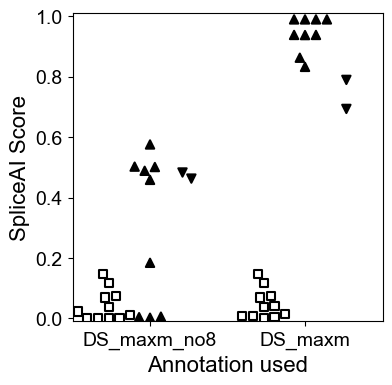

In [63]:
fig, ax = plt.subplots( 1, 1,
                        figsize = ( 4, 4 ) )

#dummy plots to get markers
a = ax.scatter( [ 1, 2 ], [ 3, 4 ], 
                 marker = 's',
                edgecolors = 'black' )
b = ax.scatter( [ 1, 2 ], [ 3, 4 ], 
                 marker = '^',
                edgecolors = 'face' )
c = ax.scatter( [ 1, 2 ], [ 3, 4 ], 
                 marker = 'v',
                edgecolors = 'face' )

square_mk, = a.get_paths()
triangle_up_mk, = b.get_paths()
triangle_down_mk, = c.get_paths()
a.remove()
b.remove()
c.remove()

ax = sns.swarmplot( data = fgfr2_known, 
                    x = 'type', 
                    y = 'DS_maxm', 
                    hue = '_clinSignCode', 
                    dodge = True,
                    palette = { 'LBB': 'white',
                               'LPP': 'black',
                               'Lit_LPP': 'black' },
                    ax = ax,
                    size = 6,
                    edgecolor = 'black',
                    linewidth = 1.5,
                   legend=None)

for path in ax.collections:
    points = path.get_offsets()
    print(f"hue: {path.get_label()}; y-values: {points.shape}")

c = ax.collections
    
for a in c[ : : n_hues ]:
    a.set_paths( [ square_mk ] )
for a in c[ 1 : : n_hues ]:
    a.set_paths( [ triangle_up_mk ] )
for a in c[ 2 : : n_hues ]:
    a.set_paths( [ triangle_down_mk ] )
    
ax.set_ylim( ( -.01, 1.01 ) )

ax.set_ylabel( 'SpliceAI Score' )
ax.set_xlabel( 'Annotation used' )

plt.savefig( '../plots/fgfr_splai_LPP_sm.pdf' )

plt.show()


In [52]:
fgfr2[ 'gene_name' ] = 'FGFR2'

In [30]:
fgfr2[ 'transcript_id_fgfr2b' ] = 'ENST00000457416.10'

In [31]:
fgfr2[ 'transcript_id_fgfr2c' ] = 'ENST00000358487.5'

In [32]:
fgfr2[ 'transcript_id_fgfr2c' ] = 'ENST00000358487.5'

In [33]:
fgfr2[ 'exon_num' ] = 8

In [34]:
fgfr2_out = fgfr2[ [ 'transcript_id_fgfr2b', 'exon_num', 'gene_name', 'chrom', 'pos', 'ref', 'alt', 'DS_maxm_no8', 'DS_maxm', 'transcript_id_fgfr2c', '_clinSignCode' ] ].copy()

In [35]:
fgfr2_out = fgfr2_out.rename( columns = { 'transcript_id_fgfr2b': 'Transcript ID (FGFR2b)',
                                          'exon_num': 'Exon',
                                            'gene_name': 'Gene', 
                                            'chrom': 'Chrom', 
                                            'pos': 'HG38 pos', 
                                            'DS_maxm_no8': 'SpliceAI (FGFR2b)', 
                                            'DS_maxm': 'SpliceAI (FGFR2c)', 
                                            'transcript_id_fgfr2c': 'Transcript ID (FGFR2c)', 
                                            '_clinSignCode': 'ClinVar/Literature Interpretation' } )

In [36]:
fgfr2_out.to_csv( '../output/FGFR2_supp.txt',
                sep = '\t',
                index = False )